In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import pdb

# supporting:

sys.path.insert(0,'..')
from config import global_config
from dataset import LaneNetDataset
from model import vgg_encoder
from model import fcn_decoder

Mainly loss calculation and inference function

In [110]:
class LaneNet(nn.Module):

    def __init__(self, use_cuda=True):
        super(LaneNet, self).__init__()
        self.encoder = vgg_encoder.VGGEncoder()
        self.decoder = fcn_decoder.FCNDecoder()
        self.conv1 = nn.Conv2d(64, 3, kernel_size=1, bias=False)  # pixembedding
        self.entropy = nn.CrossEntropyLoss()
        self.use_cuda = use_cuda
    
    def forward(self, src):
        # encode
        ret = self.encoder(src)
        # decode
        decode_logits, decode_deconv  = self.decoder(ret)
        pix_embedding = F.relu(self.conv1(decode_deconv))
        return (decode_logits, pix_embedding)

    def inference(self, src):
        decode_logits, pix_embedding  = self.forward(src)
        
        binary_seg_ret = F.softmax(decode_logits)
        binary_seg_ret = binary_seg_ret.argmax(1)
        
        return (binary_seg_ret, pix_embedding) 
    
    def compute_loss(self, src, binary, instance):
        # preprocess label images
        if len(binary.shape) == 4:
            binary = binary.squeeze(1)
        if len(instance.shape) == 4:
            instance = instance.squeeze(1)
            
        # Get predictions
        decode_logits, pix_embedding = self.forward(src)

        # step 1:
        # calculate loss between binary and decode logits
        # use softmax_cross_entropy
        decode_logits_reshape = decode_logits.view([decode_logits.shape[0], 
                                                    decode_logits.shape[1], 
                                                    decode_logits.shape[2] * decode_logits.shape[3]])
        binary_reshape = binary.view(binary.shape[0],
                                     binary.shape[1]*binary.shape[2])
        binary_reshape = binary_reshape.long()
        binary_segmentation_loss = self.entropy(decode_logits_reshape, binary_reshape)

        # step 2:
        # calculate discriminative loss between deconv and instance
        disc_loss, l_var, l_dist, l_reg = \
                self.discriminative_loss(pix_embedding, instance, 0.5, 3.0, 1.0, 1.0, 0.001)
        
        total_loss = 0.7*binary_segmentation_loss + 0.3*disc_loss
        
        return total_loss, binary_segmentation_loss, disc_loss, decode_logits, pix_embedding
        
    def discriminative_loss(self, prediction, correct_label,
                        delta_v, delta_d, param_var, param_dist, param_reg):
        
        # saving list (maybe implement dynamic tensor?)
        output_ta_loss = []
        output_ta_var = []
        output_ta_dist = []
        output_ta_reg = []
        
        # for each image calculate the loss
        i = 0
        while i < prediction.shape[0]:
            # calculate discrimitive loss for single image
            single_prediction = prediction[i]
            single_label = correct_label[i]
            # pdb.set_trace()
            disc_loss, l_var, l_dist, l_reg = self.discriminative_loss_single(
                single_prediction, single_label, delta_v, delta_d, param_var, param_dist, param_reg)
            
            output_ta_loss.append(disc_loss.unsqueeze(0))
            output_ta_var.append(l_var.unsqueeze(0))
            output_ta_dist.append(l_dist.unsqueeze(0))
            output_ta_reg.append(l_reg.unsqueeze(0))
            
            i += 1  # next image in batch
        
        out_loss_op = torch.cat(output_ta_loss)
        out_var_op = torch.cat(output_ta_var)
        out_dist_op = torch.cat(output_ta_dist)
        out_reg_op = torch.cat(output_ta_reg)
        
        # calculate mean of the batch
        disc_loss = out_loss_op.mean()
        l_var = out_var_op.mean()
        l_dist = out_dist_op.mean()
        l_reg = out_reg_op.mean()

        return disc_loss, l_var, l_dist, l_reg
        
    def discriminative_loss_single(
            self,
            prediction,
            correct_label,
            delta_v,
            delta_d,
            param_var,
            param_dist,
            param_reg):
        '''
        The example partition loss function mentioned in the paper equ(1)
        :param prediction: inference of network
        :param correct_label: instance label
        :param delta_v: cutoff variance distance
        :param delta_d: curoff cluster distance
        :param param_var: weight for intra cluster variance
        :param param_dist: weight for inter cluster distances
        :param param_reg: weight regularization
        '''
        
        feature_dim = prediction.shape[0]
        # Make it a single line
        correct_label = correct_label.view([correct_label.shape[0] * correct_label.shape[1]]).float()
        reshaped_pred = prediction.view([feature_dim, prediction.shape[1] * prediction.shape[2]]).float()
        
        # Get unique labels
        unique_labels, unique_id = torch.unique(correct_label, sorted=True, return_inverse=True)
        _, counts = np.unique(unique_id, return_counts=True)
        print(unique_labels)
        num_instances = len(unique_labels)
        counts = torch.tensor(counts, dtype=torch.float32)
        print(counts)
        if self.use_cuda:
            counts = counts.cuda()

        # Calculate the pixel embedding mean vector
        if self.use_cuda:
            segmented_sum = torch.zeros(feature_dim, num_instances).cuda().scatter_add(1, unique_id.repeat([feature_dim,1]), reshaped_pred)
        else:
            segmented_sum = torch.zeros(feature_dim, num_instances).scatter_add(1, unique_id.repeat([feature_dim,1]), reshaped_pred)
        print(segmented_sum)
        mu = torch.div(segmented_sum, counts)
        print(mu)
        mu_expand = torch.gather(mu, 1, unique_id.repeat([feature_dim,1]))

        # Calculate loss(var)
        
        distance = (mu_expand - reshaped_pred).t().norm(dim=1)  
        distance = 255. * distance - delta_v  # delta_v too big!!!
        distance = torch.clamp(distance, min=0.)   # min is 0.
        distance = distance.pow(2)
        print(distance)
        
        if self.use_cuda:
            l_var = torch.zeros(num_instances).cuda().scatter_add(0, unique_id, distance)
        else:
            l_var = torch.zeros(num_instances).scatter_add(0, unique_id, distance)    
        l_var = torch.div(l_var, counts)
        l_var = l_var.sum()
        num_instances_tensor = torch.tensor(num_instances, dtype=torch.float32)
        if self.use_cuda:
            num_instances_tensor = num_instances_tensor.cuda()
        l_var = torch.div(l_var, num_instances_tensor)  # single value 
        
        # Calculate the loss(dist) of the formula
        mu_diff = []
        mu_t = mu.t()
        for i in range(num_instances):
            for j in range(num_instances):
                if i != j:
                    diff = mu_t[i] - mu_t[j]
                    mu_diff.append(diff.unsqueeze(0))
                    
        mu_diff = torch.cat(mu_diff)
        print(mu_diff)
        mu_norm = mu_diff.norm(dim=1)
        mu_norm = delta_d - mu_norm  # delta_d too big
        mu_norm = torch.clamp(mu_norm, min=0.)
        mu_norm = mu_norm.pow(2)
        
        l_dist = mu_norm.mean()
        print(l_dist)
        
        # Calculate the regular term loss mentioned in the original Discriminative Loss paper
        l_reg = mu.norm(dim=1).mean()

        # Consolidation losses are combined according to the parameters mentioned in the original Discriminative Loss paper
        param_scale = 1.
        l_var = param_var * l_var
        l_dist = param_dist * l_dist
        l_reg = param_reg * l_reg

        loss = param_scale * (l_var + l_dist + l_reg)
        print(l_var, l_dist, l_reg)
        return loss, l_var, l_dist, l_reg


### Testing on images:


In [111]:
import os
import sys
sys.path.insert(0,'..')
from config import global_config
from dataset import LaneNetDataset

TRAIN_FILE = '/home/ubuntu/dev/LaneNet-Pytorch/data/training_data/train.txt'
CFG = global_config.cfg

dataset = LaneNetDataset(TRAIN_FILE, CFG, True)
inputs = next(iter(dataset))  # (src, binary, instance)

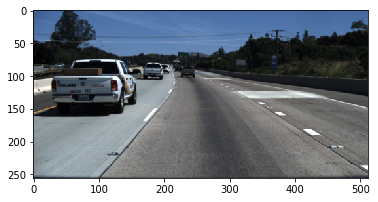

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
src = dataset.unnormalize(inputs[0])
src = dataset.tensor2pil(src)
plt.imshow(src)

In [113]:
lane_net = LaneNet(use_cuda=False)

src = inputs[0].unsqueeze(0)
binary = inputs[1]
instance = inputs[2]

In [114]:
total_loss, binary_loss, disc_loss, _, _ = lane_net.compute_loss(src, binary, instance)

tensor([0.0000, 0.2510, 0.5020, 0.7490, 1.0000])
tensor([128380.,    530.,    574.,    840.,    748.])
tensor([[216.2585,   1.4637,   1.1356,   2.0733,   1.4278],
        [204.3439,   1.4907,   1.1978,   1.5773,   1.1019],
        [258.4599,   1.5179,   1.4089,   1.9829,   1.4646]],
       grad_fn=<ScatterAddBackward>)
tensor([[0.0017, 0.0028, 0.0020, 0.0025, 0.0019],
        [0.0016, 0.0028, 0.0021, 0.0019, 0.0015],
        [0.0020, 0.0029, 0.0025, 0.0024, 0.0020]], grad_fn=<DivBackward1>)
tensor([7.9990e-02, 4.2965e-06, 2.5429e+00,  ..., 2.4800e+01, 2.4344e-02,
        1.5353e+00], grad_fn=<PowBackward0>)
tensor([[-0.0011, -0.0012, -0.0009],
        [-0.0003, -0.0005, -0.0004],
        [-0.0008, -0.0003, -0.0003],
        [-0.0002,  0.0001,  0.0001],
        [ 0.0011,  0.0012,  0.0009],
        [ 0.0008,  0.0007,  0.0004],
        [ 0.0003,  0.0009,  0.0005],
        [ 0.0009,  0.0013,  0.0009],
        [ 0.0003,  0.0005,  0.0004],
        [-0.0008, -0.0007, -0.0004],
        [-0.000

In [93]:
total_loss, binary_loss, disc_loss

(tensor(3.1920, grad_fn=<ThAddBackward>),
 tensor(0.6934, grad_fn=<NllLoss2DBackward>),
 tensor(9.0220, grad_fn=<MeanBackward1>))

Why is segmented sum always different when it's the same image?

1:
tensor([[203.2669,   1.2100,   0.9461,   1.3458,   1.0570],
        [232.0724,   1.4836,   1.4230,   1.9454,   1.3815],
        [281.5567,   1.4731,   1.5041,   2.2880,   1.6844]])

2:        
tensor([[251.6447,   1.6737,   1.4360,   1.8905,   1.5554],
        [234.6999,   1.3708,   1.7312,   1.7485,   1.5232],
        [266.7266,   1.7886,   1.6738,   2.3004,   1.6799]])
        
